In [23]:
!pip install tqdm

In [24]:
from tqdm import tqdm
import time

# This loop will have a progress bar
for i in tqdm(range(10)):
    time.sleep(0.1)  # Simulating some work

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.38it/s]


In [ ]:
# userDict: keys -> users, values -> pairs (item, rating)
# itemDict: keys -> items, values -> pairs (user, rating)

In [10]:
from functools import reduce
import numpy

In [6]:
def ItemRepRank(userDict, itemDict, nIt = 10, lbda = .1):
    reputations = None
    possible_ratings = sorted(list(reduce(lambda r, el: set(list(r)+list(el)), \
            map(lambda x:map(lambda y:y[1],x), \
            userDict.values()), set())))
    rankings = {k: (lambda x: 0 if len(x) == 0 else \
            numpy.mean(x))(list(map(lambda x:x[1], v))) \
            for k,v in itemDict.items()}
    for it in range(nIt):
        
        # Reputation Update
        reputations = { item: {x:1-lbda*abs(x-rankings[item]) \
                for x in possible_ratings} \
                for item, lst in itemDict.items()}

        # Ranking Update
        rankings = {k: (lambda x: 0 if len(x) == 0 else \
                sum(reputations[k][y[1]]*y[1] for y in x)/\
                sum(reputations[k][y[1]] for y in x))(v)
            for k,v in itemDict.items()}
        
    return rankings, reputations

In [4]:
def UserRepRank(userDict, itemDict, nIt = 10, lbda = .1):
    reputations = None
    rankings = {k: (lambda x: 0 if len(x) == 0 else \
            numpy.mean(x))(list(map(lambda x:x[1], v))) \
            for k,v in itemDict.items()}
    for it in range(nIt):
        
        # Reputation Update
        reputations = { usr: 1-(lbda/len(lst))*\
                sum(abs(r-rankings[i]) for i, r in lst) \
                for usr, lst in userDict.items()}
        
        # Ranking Update
        rankings = {k: (lambda x: 0 if len(x) == 0 else \
                sum(reputations[u]*r for u, r in x)/\
                sum(reputations[u] for u, _ in x))(v)
            for k,v in itemDict.items()}
        
    return rankings, reputations     

In [5]:
def UserRepRankLi(userDict, itemDict, nIt = 10, lbda = .1):
    reputations = None
    rankings = {k: (lambda x: 0 if len(x) == 0 else \
            numpy.mean(x))(list(map(lambda x:x[1], v))) \
            for k,v in itemDict.items()}
    for it in range(nIt):
        
        # Reputation Update
        reputations = { usr: 1-(lbda/len(lst))*\
                sum(abs(r-rankings[i]) for i, r in lst) \
                for usr, lst in userDict.items()}
        
        # Ranking Update
        rankings = {k: (lambda x: 0 if len(x) == 0 else \
                sum(reputations[u]*r for u, r in x)/\
                len(x))(v)
            for k,v in itemDict.items()}
        
    return rankings, reputations    

In [261]:
userDict, itemDict = {}, {}
f = open('ml-100k/u.data')
for line in f.readlines():
    usr, itm, rat = line.split()[:-1]
    usr, itm, rat = int(usr),int(itm),int(rat)/5
    if usr in userDict:
        userDict[usr].append((itm, rat))
    else:
        userDict[usr] = [(itm, rat)]
    if itm in itemDict:
        itemDict[itm].append((usr, rat))
    else:
        itemDict[itm] = [(usr, rat)]
f.close()

In [264]:
len(userDict.keys()),len(itemDict.keys()),reduce(lambda r,x:r+len(x),itemDict.values(),0)

(943, 1682, 100000)

In [16]:
reduce(lambda r, x: r if len(itemDict[r]) > len(itemDict[x]) else x, itemDict.keys())

50

In [17]:
len(itemDict[50])

583

In [51]:
ranksUR, _ = UserRepRank(userDict, itemDict)
ranksIR, _ = ItemRepRank(userDict, itemDict)
ranksLi, _ = UserRepRankLi(userDict, itemDict)

In [27]:
mri = 50
userMRI = len(itemDict[mri])
profitUR, profitIR, profitLi = [], [], []
wealthUR, wealthIR, wealthLi = ranksUR[mri]*userMRI, ranksIR[mri]*userMRI, ranksLi[mri]*userMRI

userDictCpy = {k:[(a,b) for a,b in v] for k,v in userDict.items()}
itemDictCpy = {k:[(a,b) for a,b in v] for k,v in itemDict.items()}

userNonMax = list(filter(lambda x: x[1] < 1, itemDictCpy[mri]))   

cost = 0
for (u, r) in tqdm(userNonMax):
    cost += abs(1-r)
    itemDictCpy[mri] = [(usr, rat) for (usr, rat) in itemDictCpy[mri] if usr != u] + [(u, 1)]
    userDictCpy[u]   = [(itm, rat) for (itm, rat) in userDictCpy[u] if itm != mri] + [(mri, 1)]
    ranksUR_, _ = UserRepRank(userDictCpy, itemDictCpy)
    ranksIR_, _ = ItemRepRank(userDictCpy, itemDictCpy)
    ranksLi_, _ = UserRepRankLi(userDictCpy, itemDictCpy)
    profitUR.append(ranksUR_[mri]*userMRI - wealthUR - cost)    
    profitIR.append(ranksIR_[mri]*userMRI - wealthIR - cost)    
    profitLi.append(ranksLi_[mri]*userMRI - wealthLi - cost)
print('done!')

100%|█████████████████████████████████████████| 258/258 [05:48<00:00,  1.35s/it]

done!


In [28]:
profitUR[-1], profitIR[-1], profitLi[-1]

(-0.06139558488776231, -0.7600455821062297, -1.1371722609995487)

In [35]:
userDict, itemDict = {}, {}
f = open('Amazon_Instant_Video_5.json')
for line in f.readlines():
    data = list(map(lambda x:x.split(': ')[1],filter(lambda el:'"reviewerID"' in el.split(':')[0] or \
                '"asin"' in el.split(':')[0] or '"overall"' in el.split(': ')[0], line[1:-1].split(', '))))
    usr, itm, rat = data[0],data[1],(float(data[2]))/5
    if usr in userDict:
        userDict[usr].append((itm, rat))
    else:
        userDict[usr] = [(itm, rat)]
    if itm in itemDict:
        itemDict[itm].append((usr, rat))
    else:
        itemDict[itm] = [(usr, rat)]
f.close()


ranksIR, _ = ItemRepRank(userDict, itemDict)
ranksUR, _ = UserRepRank(userDict, itemDict)
ranksLi, _ = UserRepRankLi(userDict, itemDict)

In [37]:
mri = reduce(lambda r, x: r if len(itemDict[r]) > len(itemDict[x]) else x, itemDict.keys())
userMRI = len(itemDict[mri])
profitUR, profitIR, profitLi = [], [], []
wealthUR, wealthIR, wealthLi = ranksUR[mri]*userMRI, ranksIR[mri]*userMRI, ranksLi[mri]*userMRI

userDictCpy = {k:[(a,b) for a,b in v] for k,v in userDict.items()}
itemDictCpy = {k:[(a,b) for a,b in v] for k,v in itemDict.items()}

userNonMax = list(filter(lambda x: x[1] < 1, itemDictCpy[mri]))   

cost = 0
for (u, r) in tqdm(userNonMax):
    cost += abs(1-r)
    itemDictCpy[mri] = [(usr, rat) for (usr, rat) in itemDictCpy[mri] if usr != u] + [(u, 1)]
    userDictCpy[u]   = [(itm, rat) for (itm, rat) in userDictCpy[u] if itm != mri] + [(mri, 1)]
    ranksUR_, _ = UserRepRank(userDictCpy, itemDictCpy)
    ranksIR_, _ = ItemRepRank(userDictCpy, itemDictCpy)
    ranksLi_, _ = UserRepRankLi(userDictCpy, itemDictCpy)
    profitUR.append(ranksUR_[mri]*userMRI - wealthUR - cost)    
    profitIR.append(ranksIR_[mri]*userMRI - wealthIR - cost)    
    profitLi.append(ranksLi_[mri]*userMRI - wealthLi - cost)
print('done!')
profitUR[-1], profitIR[-1], profitLi[-1]

100%|█████████████████████████████████████████| 205/205 [02:16<00:00,  1.51it/s]

done!


(-0.2944024687154041, -0.8325994676261388, -0.4006578113640984)

In [38]:
round(-0.294402468715,5)

-0.2944

In [42]:
print(reduce(lambda r,x : r+'('+str(x[0])+','+('{:.5f}'.format(x[1]))+')', [(i, y) for i, y in enumerate(profitIR)], ''))

(0,0.00516)(1,0.00952)(2,0.01390)(3,0.01830)(4,0.02271)(5,0.02784)(6,0.03292)(7,0.03736)(8,0.04181)(9,0.03910)(10,0.03620)(11,0.04064)(12,0.03753)(13,0.04226)(14,0.04669)(15,0.05114)(16,0.04769)(17,0.05214)(18,0.05659)(19,0.06105)(20,0.06552)(21,0.07001)(22,0.07453)(23,0.05402)(24,0.04984)(25,0.02859)(26,0.03297)(27,0.03735)(28,0.04175)(29,0.04615)(30,0.05009)(31,0.05449)(32,0.05889)(33,0.06330)(34,0.05826)(35,0.06197)(36,0.06633)(37,0.06995)(38,0.07350)(39,0.07783)(40,0.08217)(41,0.08561)(42,0.08993)(43,0.09426)(44,0.09757)(45,0.10188)(46,0.10510)(47,0.08103)(48,0.08526)(49,0.08948)(50,0.09371)(51,0.09794)(52,0.10077)(53,0.10352)(54,0.10618)(55,0.11033)(56,0.11287)(57,0.11700)(58,0.12112)(59,0.12524)(60,0.12761)(61,0.13169)(62,0.13394)(63,0.13800)(64,0.14012)(65,0.14414)(66,0.14815)(67,0.12118)(68,0.12511)(69,0.12681)(70,0.13070)(71,0.13457)(72,0.13611)(73,0.13994)(74,0.14377)(75,0.14759)(76,0.15140)(77,0.15269)(78,0.15387)(79,0.15760)(80,0.14767)(81,0.13746)(82,0.14104)(83,0.11100)(8

In [44]:
mri = reduce(lambda r, x: r if len(itemDict[r]) > len(itemDict[x]) else x, itemDict.keys())
userMRI = len(itemDict[mri])
profitUR, profitIR = [], []
wealthUR, wealthIR = ranksUR[mri]*userMRI, ranksIR[mri]*userMRI 

userDictCpy = {k:[(a,b) for a,b in v] for k,v in userDict.items()}
itemDictCpy = {k:[(a,b) for a,b in v] for k,v in itemDict.items()}

#userNonMax = list(filter(lambda x: x[1] < 1, itemDictCpy[mri]))   

cost = 0
for (u, r) in tqdm(itemDictCpy[mri]):
    cost = abs(1-r)
    itemDictCpy[mri] = [(usr, rat) for (usr, rat) in itemDictCpy[mri] if usr != u] + [(u, 1)]
    userDictCpy[u]   = [(itm, rat) for (itm, rat) in userDictCpy[u] if itm != mri] + [(mri, 1)]
    ranksUR_, _ = UserRepRank(userDictCpy, itemDictCpy)
    ranksIR_, _ = ItemRepRank(userDictCpy, itemDictCpy)
    ranksLi_, _ = UserRepRankLi(userDictCpy, itemDictCpy)
    profitUR.append(ranksUR_[mri]*userMRI - wealthUR - cost)    
    profitIR.append(ranksIR_[mri]*userMRI - wealthIR - cost)    
    userDictCpy = {k:[(a,b) for a,b in v] for k,v in userDict.items()}
    itemDictCpy = {k:[(a,b) for a,b in v] for k,v in itemDict.items()}
    itemDictCpy[mri] = [(usr, rat) for (usr, rat) in itemDictCpy[mri] if usr != u] + [(u, r)]
    userDictCpy[u]   = [(itm, rat) for (itm, rat) in userDictCpy[u] if itm != mri] + [(mri, r)]
print('done!')
reduce(lambda r,x: r+(x>0), profitUR, 0), reduce(lambda r,x: r+(x>0), profitIR, 0)

100%|█████████████████████████████████████████| 455/455 [05:26<00:00,  1.40it/s]

done!


(139, 247)

In [7]:
def filterRank(itemDict):
    done = {}
    ratDict = {k:[el[1] for el in v] for k, v in itemDict.items()}
    rankings = {k: numpy.mean(v) for k, v in ratDict.items()}
    while len(done) != len(ratDict.keys()):
        for item in ratDict.keys():
            if item not in done:
                std = numpy.std(ratDict[item])
                n = len(ratDict[item])
                ratDict[item] = list(filter(lambda rat:abs(rat-rankings[item])**2 <= std, ratDict[item]))
                if len(ratDict[item]) == n:
                    done[item] = True
                else:
                    rankings[item] = numpy.mean(ratDict[item])
    return rankings    

In [8]:
def filterRankFast(itemDict):
    ratDict = {k:[el[1] for el in v] for k, v in itemDict.items()}
    rankings = {k: numpy.mean(v) for k, v in ratDict.items()}
    for item in ratDict.keys():
        while True:
            std = numpy.std(ratDict[item])
            n = len(ratDict[item])
            ratDict[item] = list(filter(lambda rat:abs(rat-rankings[item])**2 <= std, ratDict[item]))
            if len(ratDict[item]) == n:
                break
            rankings[item] = numpy.mean(ratDict[item])
    return rankings 

In [237]:
ranksNew1 = filterRank(itemDict)
ranksNew2 = filterRankFast(itemDict)


In [242]:
%timeit filterRank(itemDict)

2.58 s ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [245]:
%timeit filterRankFast(itemDict)

2.51 s ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [246]:
ranksNew1 == ranksNew2

True

In [192]:
ranksNew[1], ranksIR[1], ranksUR[1]

(0.786036036036036, 0.7764182659547761, 0.7757483034941202)

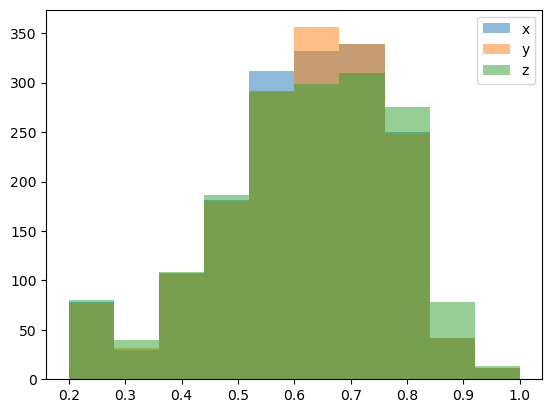

In [73]:
import matplotlib.pyplot as plt

plt.hist(ranksAVG.values(), alpha=0.5, label='x')
plt.hist(ranksUR.values(), alpha=0.5, label='y')
plt.hist(ranksNew.values(), alpha=0.5, label='z')
plt.legend(loc='upper right')
plt.show()

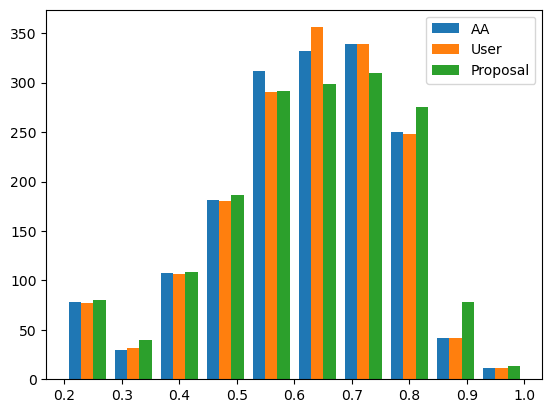

In [76]:
x, y, z = list(ranksAVG.values()), list(ranksUR.values()), list(ranksNew.values())

plt.hist([x, y, z], label=['AA', 'User', 'Proposal'])
plt.legend(loc='upper right')
plt.show()

In [61]:
from scipy.stats import kendalltau

In [62]:
ranksAVG, _ = UserRepRank(userDict, itemDict, nIt=0, lbda=0)

In [66]:
kendalltau(list(ranksAVG.values()), list(ranksUR.values()))

SignificanceResult(statistic=0.9947327181836696, pvalue=0.0)

In [71]:
kendalltau(list(ranksAVG.values()), list(ranksNew.values()))

SignificanceResult(statistic=0.9607314598564557, pvalue=0.0)

In [258]:
%timeit filterRank(itemDict)

132 ms ± 6.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [259]:
%timeit filterRankFast(itemDict)

130 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [260]:
%timeit UserRepRank(userDict, itemDict, nIt=20, lbda=.1)

1.23 s ± 47.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


100%|█████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


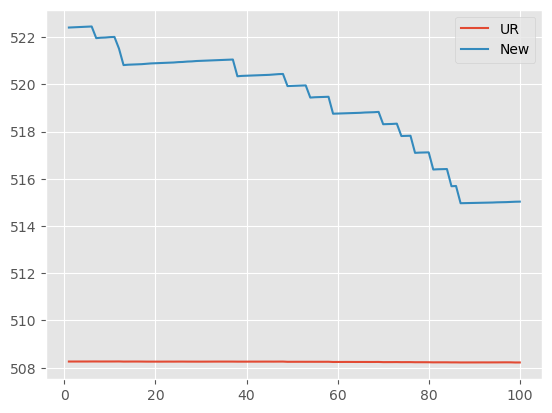

In [161]:
ranksUR, _ = UserRepRank(userDict, itemDict)
ranksAA, _ = UserRepRank(userDict, itemDict, nIt=0, lbda=0)
ranksNew = filterRank(itemDict)

mri = 50
userMRI = len(itemDict[mri])
profitUR, profitAA, profitNew = [], [], []
wealthUR, wealthAA, wealthNew = ranksUR[mri]*userMRI, ranksAA[mri]*userMRI, ranksNew[mri]*userMRI

userDictCpy = {k:[(a,b) for a,b in v] for k,v in userDict.items()}
itemDictCpy = {k:[(a,b) for a,b in v] for k,v in itemDict.items()}

userNonMax = list(filter(lambda x: x[1] < 1, itemDictCpy[mri]))   

cost = 0
for (u, r) in tqdm(userNonMax[:100]):
    cost += abs(1-r)
    itemDictCpy[mri] = [(usr, rat) for (usr, rat) in itemDictCpy[mri] if usr != u] + [(u, 1)]
    userDictCpy[u]   = [(itm, rat) for (itm, rat) in userDictCpy[u] if itm != mri] + [(mri, 1)]
    ranksUR_, _ = UserRepRank(userDictCpy, itemDictCpy)
    ranksAA_, _ = UserRepRank(userDictCpy, itemDictCpy, nIt=0, lbda=0)
    ranksNew_ = filterRank(itemDictCpy)
    profUR = ranksUR_[mri]*userMRI - cost
    profNew = ranksNew_[mri]*userMRI - cost
    if profUR < 0 or profNew < 0:
        break
    profitUR.append(profUR)    
    profitNew.append(profNew)

plt.plot(list(range(1, len(profitUR)+1)), profitUR, label='UR')
plt.plot(list(range(1, len(profitNew)+1)), profitNew, label='New')
plt.legend()

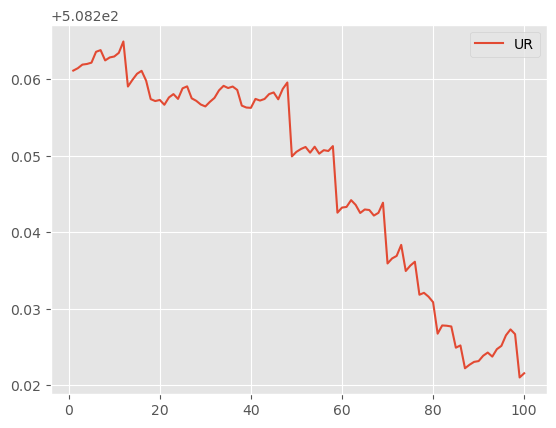

In [178]:
plt.plot(list(range(1, len(profitUR)+1)), profitUR, label='UR')
plt.legend()

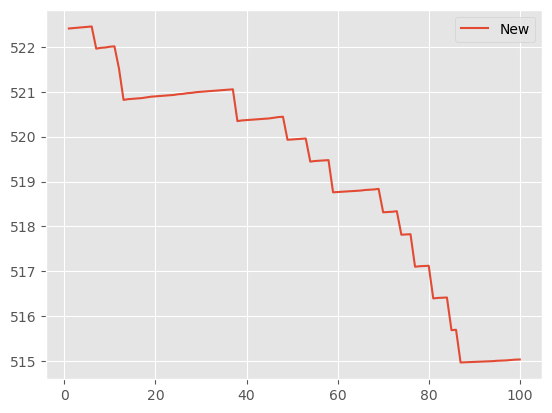

In [177]:
plt.plot(list(range(1, len(profitNew)+1)), profitNew, label='New')
plt.legend()

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{crimson2143940}{RGB}{214,39,40}
\definecolor{dimgray85}{RGB}{85,85,85}
\definecolor{gainsboro229}{RGB}{229,229,229}
\definecolor{lightgray204}{RGB}{204,204,204}
\definecolor{steelblue31119180}{RGB}{31,119,180}

\begin{axis}[
axis background/.style={fill=gainsboro229},
axis line style={white},
tick align=outside,
tick pos=left,
x grid style={white},
xmajorgrids,
xmin=-3.95, xmax=104.95,
xtick style={color=dimgray85},
y grid style={white},
ylabel=\textcolor{crimson2143940}{UR},
ymajorgrids,
ymin=508.218840534263, ymax=508.267087252424,
ytick style={color=dimgray85},
ytick={508.21,508.22,508.23,508.24,508.25,508.26,508.27},
yticklabels={0.01,0.02,0.03,0.04,0.05,0.06,0.07}
]
\addplot [semithick, crimson2143940]
table {%
1 508.261093233016
2 508.26140584353
3 508.261873667047
4 508.261957263728
5 508.262129261754
6 508.263545242589
7 508.26376691018
8 508.26242261115
9 508.26280813579
10 508.262934337056
11 

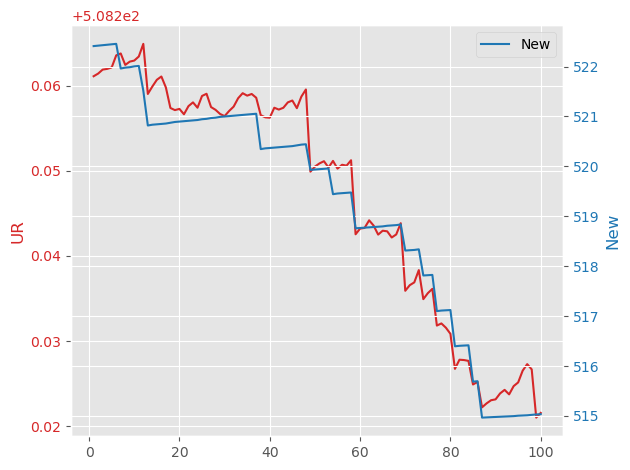

In [191]:
# Create some mock data
import numpy as np

t = list(range(1, len(profitNew)+1))
data1 = profitUR
data2 = profitNew

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('UR', color=color)
ax1.plot(t, data1, color=color, label='UR')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('New', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color, label='New')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.legend()

fig = plt.gcf()
tikzplotlib_fix_ncols(fig)

print(tikzplotlib.get_tikz_code())

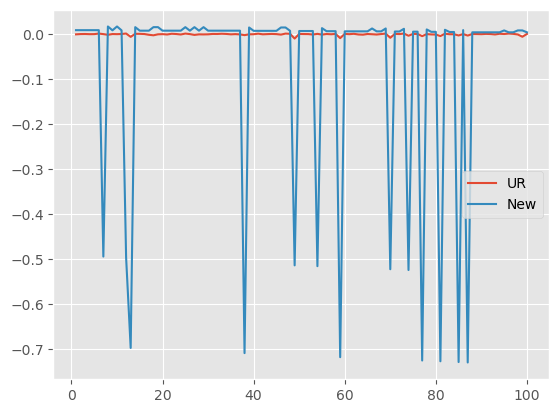

In [175]:
plt.plot(list(range(1, len(profitUR)+1)), list(map(lambda x,y:x-y, profitUR, [wealthUR]+profitUR[:-1])), label='UR')
plt.plot(list(range(1, len(profitNew)+1)), list(map(lambda x,y:x-y, profitNew, [wealthNew]+profitNew[:-1])), label='New')
plt.legend()

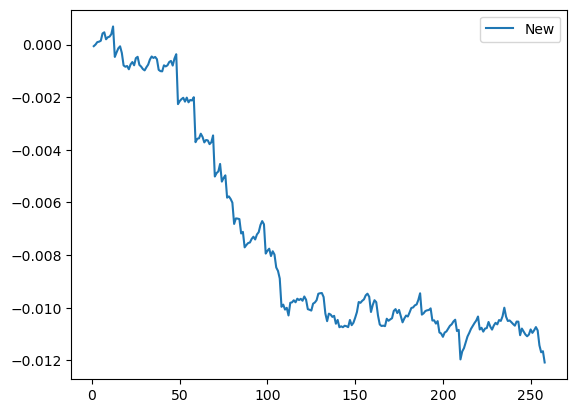

In [125]:
plt.plot(list(range(1, len(profitUR)+1)), [100*(x-wealthUR)/wealthUR for x in profitUR], label='New')
plt.legend()

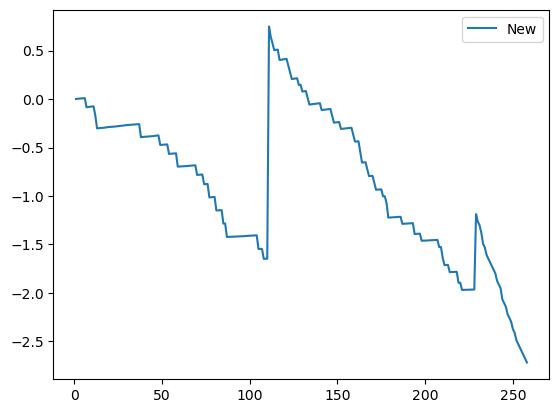

In [126]:
plt.plot(list(range(1, len(profitNew)+1)), [100*(x-wealthNew)/wealthNew for x in profitNew], label='New')
plt.legend()

100%|█████████████████████████████████████████████| 8/8 [05:36<00:00, 42.01s/it]


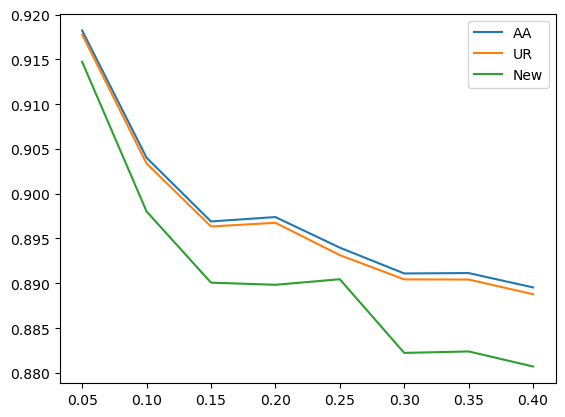

In [106]:
import random

userDictCpy, itemDictCpy = {}, {}
f = open('ml-100k/u.data')
for line in f.readlines():
    usr, itm, rat = line.split()[:-1]
    usr, itm, rat = int(usr),int(itm),int(rat)/5
    if usr in userDictCpy:
        userDictCpy[usr].append((itm, rat))
    else:
        userDictCpy[usr] = [(itm, rat)]
    if itm in itemDictCpy:
        itemDictCpy[itm].append((usr, rat))
    else:
        itemDictCpy[itm] = [(usr, rat)]
f.close()

'''aux= []
for itm, lst in itemDictCpy.items():
    if len(lst) < 5:
        aux.append(itm)
        for u, _ in lst:
            userDictCpy[u] = list(filter(lambda x:x[0] != itm, userDictCpy[u]))
for itm in aux:
    itemDictCpy.pop(itm)'''


rankings, _ = UserRepRank(userDictCpy, itemDictCpy, nIt=0, lbda=0)
rankingsI = filterRank(itemDictCpy)
rankingsU, _ = UserRepRank(userDictCpy, itemDictCpy, nIt=20, lbda=0.1)

n_usr = len(userDictCpy.keys())

N, K = 30, round(.5+numpy.mean([len(v) for _, v in userDictCpy.items()]))
rAA = [[] for i in range(N)]
rItm = [[] for i in range(N)]
rUsr = [[] for i in range(N)]

for spam in tqdm([.05,.1,.15,.2,.25,.3,.35,.4]):
    for i in range(N):
        userDict_perc = {k:[(a,b) for a,b in v] for k,v in userDictCpy.items()}
        itemDict_perc = {k:[(a,b) for a,b in v] for k,v in itemDictCpy.items()}
        randomItems = random.sample(list(itemDictCpy.keys()), K)
        for u in range(n_usr+1, int(max(userDictCpy.keys())+spam*(n_usr))):
            typ = 1#random.sample([0,1,2], 1)[0]
            for itm in randomItems:
                rtng = [random.sample(list(range(1,6)), 1)[0]/5, 1/5, 1.0][typ]
                userDict_perc[u] = [(itm, rtng)]
                itemDict_perc[itm] += [(u, rtng)]

        rnks = filterRank(itemDict_perc)
        rItm[i] += [(spam, kendalltau(list(rankingsI.values()),list(rnks.values()))[0])]
        rnks, _ = UserRepRank(userDict_perc, itemDict_perc, nIt=20, lbda=.1)
        rUsr[i] += [(spam, kendalltau(list(rankingsU.values()),list(rnks.values()))[0])]
        rnks, _ = UserRepRank(userDict_perc, itemDict_perc, nIt=0, lbda=0)
        rAA[i] += [(spam, kendalltau(list(rankings.values()),list(rnks.values()))[0])]
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rAA), label='AA')
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rUsr), label='UR')
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rItm), label='New')
plt.legend()

In [ ]:
ranksUR, _ = UserRepRank(userDict, itemDict)
ranksAA, _ = UserRepRank(userDict, itemDict, nIt=0, lbda=0)
ranksNew = filterRank(itemDict)

mri = 50
userMRI = len(itemDict[mri])
profitUR, profitAA, profitNew = [], [], []
wealthUR, wealthAA, wealthNew = ranksUR[mri]*userMRI, ranksAA[mri]*userMRI, ranksNew[mri]*userMRI

userDictCpy = {k:[(a,b) for a,b in v] for k,v in userDict.items()}
itemDictCpy = {k:[(a,b) for a,b in v] for k,v in itemDict.items()}

userNonMax = list(filter(lambda x: x[1] < 1, itemDictCpy[mri]))   

cost = 0
for (u, r) in tqdm(userNonMax[:100]):
    cost += abs(1-r)
    itemDictCpy[mri] = [(usr, rat) for (usr, rat) in itemDictCpy[mri] if usr != u] + [(u, 1)]
    userDictCpy[u]   = [(itm, rat) for (itm, rat) in userDictCpy[u] if itm != mri] + [(mri, 1)]
    ranksUR_, _ = UserRepRank(userDictCpy, itemDictCpy)
    ranksAA_, _ = UserRepRank(userDictCpy, itemDictCpy, nIt=0, lbda=0)
    ranksNew_ = filterRank(itemDictCpy)
    profUR = ranksUR_[mri]*userMRI - cost
    profNew = ranksNew_[mri]*userMRI - cost
    if profUR < 0 or profNew < 0:
        break
    profitUR.append(profUR)    
    profitNew.append(profNew)

plt.plot(list(range(1, len(profitUR)+1)), profitUR, label='UR')
plt.plot(list(range(1, len(profitNew)+1)), profitNew, label='New')
plt.legend()

In [89]:
def plotAvg(rItm):
    dados = []
    for i in range(len(rItm[0])):
        values = [el[i][1] for el in rItm]
        dados += [ numpy.mean(values)]
    return dados

100%|█████████████████████████████████████████████| 8/8 [05:40<00:00, 42.57s/it]


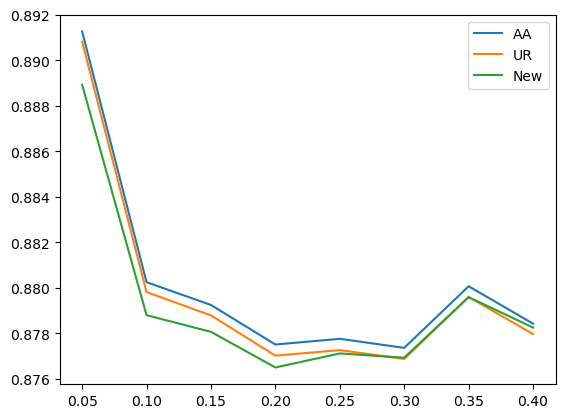

In [105]:
import random

userDictCpy, itemDictCpy = {}, {}
f = open('ml-100k/u.data')
for line in f.readlines():
    usr, itm, rat = line.split()[:-1]
    usr, itm, rat = int(usr),int(itm),int(rat)/5
    if usr in userDictCpy:
        userDictCpy[usr].append((itm, rat))
    else:
        userDictCpy[usr] = [(itm, rat)]
    if itm in itemDictCpy:
        itemDictCpy[itm].append((usr, rat))
    else:
        itemDictCpy[itm] = [(usr, rat)]
f.close()

'''aux= []
for itm, lst in itemDictCpy.items():
    if len(lst) < 5:
        aux.append(itm)
        for u, _ in lst:
            userDictCpy[u] = list(filter(lambda x:x[0] != itm, userDictCpy[u]))
for itm in aux:
    itemDictCpy.pop(itm)'''


rankings, _ = UserRepRank(userDictCpy, itemDictCpy, nIt=0, lbda=0)
rankingsI = filterRank(itemDictCpy)
rankingsU, _ = UserRepRank(userDictCpy, itemDictCpy, nIt=20, lbda=0.1)

n_usr = len(userDictCpy.keys())

N, K = 30, round(.5+numpy.mean([len(v) for _, v in userDictCpy.items()]))
rAA = [[] for i in range(N)]
rItm = [[] for i in range(N)]
rUsr = [[] for i in range(N)]

for spam in tqdm([.05,.1,.15,.2,.25,.3,.35,.4]):
    for i in range(N):
        userDict_perc = {k:[(a,b) for a,b in v] for k,v in userDictCpy.items()}
        itemDict_perc = {k:[(a,b) for a,b in v] for k,v in itemDictCpy.items()}
        randomItems = random.sample(list(itemDictCpy.keys()), K)
        for u in range(n_usr+1, int(max(userDictCpy.keys())+spam*(n_usr))):
            typ = 2 #random.sample([0,1,2], 1)[0]
            for itm in randomItems:
                rtng = [random.sample(list(range(1,6)), 1)[0]/5, 1/5, 1.0][typ]
                userDict_perc[u] = [(itm, rtng)]
                itemDict_perc[itm] += [(u, rtng)]

        rnks = filterRank(itemDict_perc)
        rItm[i] += [(spam, kendalltau(list(rankingsI.values()),list(rnks.values()))[0])]
        rnks, _ = UserRepRank(userDict_perc, itemDict_perc, nIt=20, lbda=.1)
        rUsr[i] += [(spam, kendalltau(list(rankingsU.values()),list(rnks.values()))[0])]
        rnks, _ = UserRepRank(userDict_perc, itemDict_perc, nIt=0, lbda=0)
        rAA[i] += [(spam, kendalltau(list(rankings.values()),list(rnks.values()))[0])]
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rAA), label='AA')
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rUsr), label='UR')
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rItm), label='New')
plt.legend()

100%|█████████████████████████████████████████████| 8/8 [05:32<00:00, 41.56s/it]


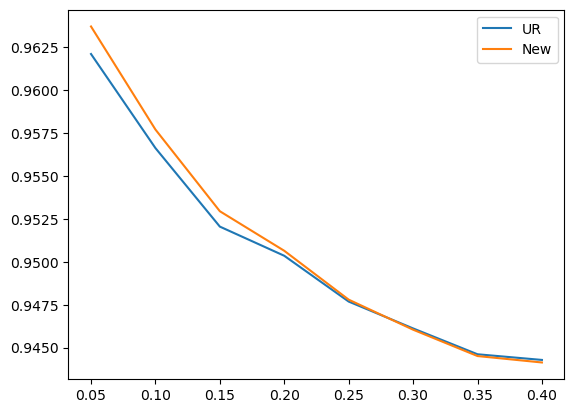

In [127]:
import random

userDictCpy, itemDictCpy = {}, {}
f = open('ml-100k/u.data')
for line in f.readlines():
    usr, itm, rat = line.split()[:-1]
    usr, itm, rat = int(usr),int(itm),int(rat)/5
    if usr in userDictCpy:
        userDictCpy[usr].append((itm, rat))
    else:
        userDictCpy[usr] = [(itm, rat)]
    if itm in itemDictCpy:
        itemDictCpy[itm].append((usr, rat))
    else:
        itemDictCpy[itm] = [(usr, rat)]
f.close()

'''aux= []
for itm, lst in itemDictCpy.items():
    if len(lst) < 5:
        aux.append(itm)
        for u, _ in lst:
            userDictCpy[u] = list(filter(lambda x:x[0] != itm, userDictCpy[u]))
for itm in aux:
    itemDictCpy.pop(itm)'''


rankings, _ = UserRepRank(userDictCpy, itemDictCpy, nIt=0, lbda=0)
rankingsI = filterRank(itemDictCpy)
rankingsU, _ = UserRepRank(userDictCpy, itemDictCpy, nIt=20, lbda=0.1)

n_usr = len(userDictCpy.keys())

N, K = 30, round(.5+numpy.mean([len(v) for _, v in userDictCpy.items()]))
rAA = [[] for i in range(N)]
rItm = [[] for i in range(N)]
rUsr = [[] for i in range(N)]

for spam in tqdm([.05,.1,.15,.2,.25,.3,.35,.4]):
    for i in range(N):
        userDict_perc = {k:[(a,b) for a,b in v] for k,v in userDictCpy.items()}
        itemDict_perc = {k:[(a,b) for a,b in v] for k,v in itemDictCpy.items()}
        randomItems = random.sample(list(itemDictCpy.keys()), K)
        for u in range(n_usr+1, int(max(userDictCpy.keys())+spam*(n_usr))):
            typ = 0 #random.sample([0,1,2], 1)[0]
            for itm in randomItems:
                rtng = [random.sample(list(range(1,6)), 1)[0]/5, 1/5, 1.0][typ]
                userDict_perc[u] = [(itm, rtng)]
                itemDict_perc[itm] += [(u, rtng)]

        rnks = filterRank(itemDict_perc)
        rItm[i] += [(spam, kendalltau(list(rankingsI.values()),list(rnks.values()))[0])]
        rnks, _ = UserRepRank(userDict_perc, itemDict_perc, nIt=20, lbda=.1)
        rUsr[i] += [(spam, kendalltau(list(rankingsU.values()),list(rnks.values()))[0])]
        #rnks, _ = UserRepRank(userDict_perc, itemDict_perc, nIt=0, lbda=0)
        #rAA[i] += [(spam, kendalltau(list(rankings.values()),list(rnks.values()))[0])]
#plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rAA), label='AA')
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rUsr), label='UR')
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rItm), label='New')
plt.legend()

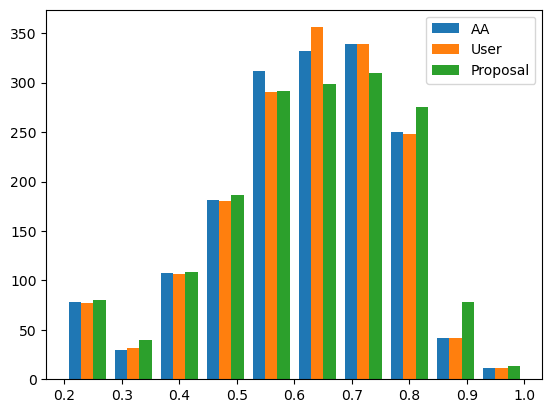

In [128]:
x, y, z = list(rankings.values()), list(rankingsU.values()), list(rankingsI.values())

plt.hist([x, y, z], label=['AA', 'User', 'Proposal'])
plt.legend(loc='upper right')
plt.show()

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{chocolate2267451}{RGB}{226,74,51}
\definecolor{dimgray85}{RGB}{85,85,85}
\definecolor{gainsboro229}{RGB}{229,229,229}
\definecolor{mediumpurple152142213}{RGB}{152,142,213}
\definecolor{steelblue52138189}{RGB}{52,138,189}

\begin{axis}[
axis background/.style={fill=gainsboro229},
axis line style={white},
tick align=outside,
tick pos=left,
x grid style={white},
xmajorgrids,
xmin=0.1688, xmax=1.0312,
xtick style={color=dimgray85},
y grid style={white},
ymajorgrids,
ymin=0, ymax=373.8,
ytick style={color=dimgray85}
]
\draw[draw=none,fill=chocolate2267451,very thin] (axis cs:0.208,0) rectangle (axis cs:0.229333333333333,78);
\addlegendimage{ybar,ybar legend,draw=none,fill=chocolate2267451,very thin}
\addlegendentry{AA}

\draw[draw=none,fill=chocolate2267451,very thin] (axis cs:0.288,0) rectangle (axis cs:0.309333333333333,30);
\draw[draw=none,fill=chocolate2267451,very thin] (axis cs:0.368,0) rectangle (axis

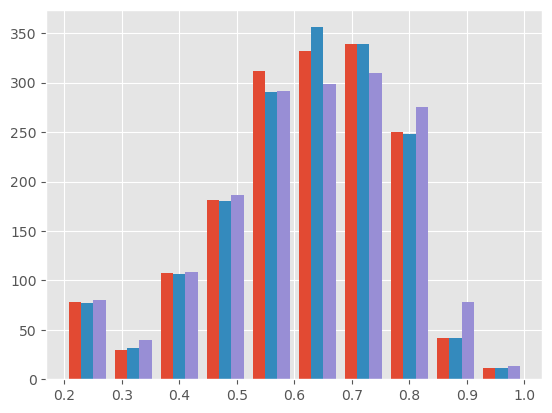

In [136]:
import tikzplotlib

plt.style.use("ggplot")

x, y, z = list(rankings.values()), list(rankingsU.values()), list(rankingsI.values())

plt.hist([x, y, z], label=['AA', 'User', 'Proposal'])
plt.grid(True)
#plt.show()

print(tikzplotlib.get_tikz_code())

In [148]:
len(plotAvg(rUsr))

8

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{chocolate2267451}{RGB}{226,74,51}
\definecolor{dimgray85}{RGB}{85,85,85}
\definecolor{gainsboro229}{RGB}{229,229,229}
\definecolor{lightgray204}{RGB}{204,204,204}
\definecolor{steelblue52138189}{RGB}{52,138,189}

\begin{axis}[
axis background/.style={fill=gainsboro229},
axis line style={white},
legend cell align={left},
legend style={fill opacity=0.8, draw opacity=1, text opacity=1, draw=lightgray204, fill=gainsboro229},
tick align=outside,
tick pos=left,
x grid style={white},
xmajorgrids,
xmin=0.0325, xmax=0.4175,
xtick style={color=dimgray85},
y grid style={white},
ymajorgrids,
ymin=0.943157404894493, ymax=0.964685698887935,
ytick style={color=dimgray85}
]
\addplot [semithick, chocolate2267451]
table {%
0.05 0.962103892889721
0.1 0.956624469299316
0.15 0.952049716232717
0.2 0.950351388735815
0.25 0.947684041078475
0.3 0.946119804170094
0.35 0.94461426669911
0.4 0.944284416340943
};
\addlegendentry{UR}

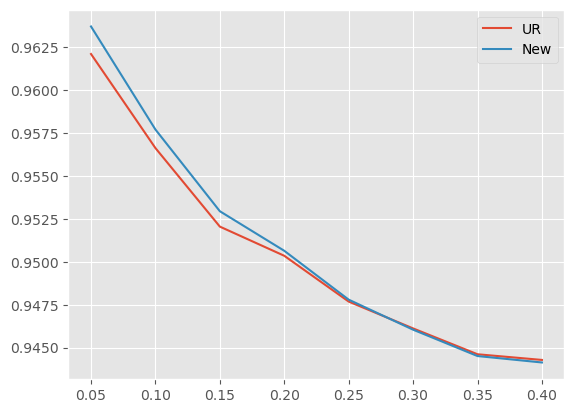

In [160]:
plt.style.use("ggplot")

plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rUsr), label='UR')
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rItm), label='New')
plt.legend()


def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

fig = plt.gcf()
tikzplotlib_fix_ncols(fig)

print(tikzplotlib.get_tikz_code())

In [19]:
userDict, itemDict = {}, {}
f = open('ml-1m/ratings.dat')
for line in f.readlines():
    usr, itm, rat = line.split('::')[:-1]
    usr, itm, rat = int(usr),int(itm),int(rat)/5
    if usr in userDict:
        userDict[usr].append((itm, rat))
    else:
        userDict[usr] = [(itm, rat)]
    if itm in itemDict:
        itemDict[itm].append((usr, rat))
    else:
        itemDict[itm] = [(usr, rat)]
f.close()

In [251]:
%timeit filterRankFast(itemDict)

1.03 s ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [252]:
%timeit UserRepRank(userDict, itemDict, nIt=20, lbda=0.1)

12.7 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
rankings, _ = UserRepRank(userDict, itemDict, nIt=0, lbda=0)
rankingsI = filterRank(itemDict)
rankingsU, _ = UserRepRank(userDict, itemDict, nIt=20, lbda=0.5)

In [21]:
kendalltau(list(rankings.values()), list(rankingsU.values()))

SignificanceResult(statistic=0.9951998341932492, pvalue=0.0)

In [22]:
kendalltau(list(rankings.values()), list(rankingsI.values()))

SignificanceResult(statistic=0.9542784766288638, pvalue=0.0)

100%|████████████████████████████████████████████| 8/8 [58:59<00:00, 442.48s/it]


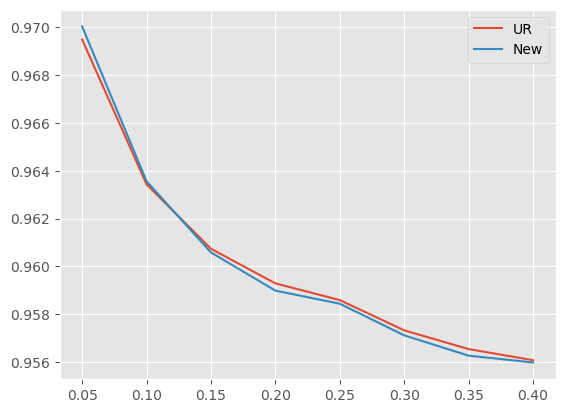

In [206]:
rankings, _ = UserRepRank(userDict, itemDict, nIt=0, lbda=0)
rankingsI = filterRank(itemDict)
rankingsU, _ = UserRepRank(userDict, itemDict, nIt=20, lbda=0.1)

n_usr = len(userDict.keys())

N, K = 30, round(.5+numpy.mean([len(v) for _, v in userDict.items()]))
rAA = [[] for i in range(N)]
rItm = [[] for i in range(N)]
rUsr = [[] for i in range(N)]

for spam in tqdm([.05,.1,.15,.2,.25,.3,.35,.4]):
    for i in range(N):
        userDict_perc = {k:[(a,b) for a,b in v] for k,v in userDict.items()}
        itemDict_perc = {k:[(a,b) for a,b in v] for k,v in itemDict.items()}
        randomItems = random.sample(list(itemDict.keys()), K)
        for u in range(n_usr+1, int((spam+1)*(n_usr))):
            typ = 0 #random.sample([0,1,2], 1)[0]
            for itm in randomItems:
                rtng = [random.sample(list(range(1,6)), 1)[0]/5, 1/5, 1.0][typ]
                userDict_perc[u] = [(itm, rtng)]
                itemDict_perc[itm] += [(u, rtng)]

        rnks = filterRank(itemDict_perc)
        rItm[i] += [(spam, kendalltau(list(rankingsI.values()),list(rnks.values()))[0])]
        rnks, _ = UserRepRank(userDict_perc, itemDict_perc, nIt=20, lbda=.1)
        rUsr[i] += [(spam, kendalltau(list(rankingsU.values()),list(rnks.values()))[0])]
        #rnks, _ = UserRepRank(userDict_perc, itemDict_perc, nIt=0, lbda=0)
        #rAA[i] += [(spam, kendalltau(list(rankings.values()),list(rnks.values()))[0])]
#plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rAA), label='AA')
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rUsr), label='UR')
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rItm), label='New')
plt.legend()

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{chocolate2267451}{RGB}{226,74,51}
\definecolor{dimgray85}{RGB}{85,85,85}
\definecolor{gainsboro229}{RGB}{229,229,229}
\definecolor{mediumpurple152142213}{RGB}{152,142,213}
\definecolor{steelblue52138189}{RGB}{52,138,189}

\begin{axis}[
axis background/.style={fill=gainsboro229},
axis line style={white},
tick align=outside,
tick pos=left,
x grid style={white},
xmajorgrids,
xmin=0.1688, xmax=1.0312,
xtick style={color=dimgray85},
y grid style={white},
ymajorgrids,
ymin=0, ymax=947.1,
ytick style={color=dimgray85}
]
\draw[draw=none,fill=chocolate2267451,very thin] (axis cs:0.208,0) rectangle (axis cs:0.229333333333333,39);
\addlegendimage{ybar,ybar legend,draw=none,fill=chocolate2267451,very thin}
\addlegendentry{AA}

\draw[draw=none,fill=chocolate2267451,very thin] (axis cs:0.288,0) rectangle (axis cs:0.309333333333333,63);
\draw[draw=none,fill=chocolate2267451,very thin] (axis cs:0.368,0) rectangle (axis

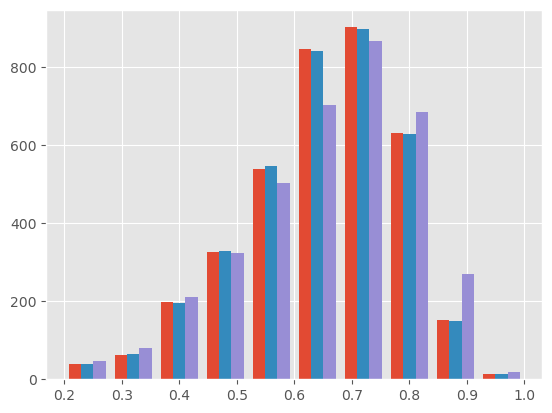

In [207]:
plt.style.use("ggplot")

x, y, z = list(rankings.values()), list(rankingsU.values()), list(rankingsI.values())

plt.hist([x, y, z], label=['AA', 'UR', 'New'])
plt.grid(True)
#plt.show()

print(tikzplotlib.get_tikz_code())

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{chocolate2267451}{RGB}{226,74,51}
\definecolor{dimgray85}{RGB}{85,85,85}
\definecolor{gainsboro229}{RGB}{229,229,229}
\definecolor{lightgray204}{RGB}{204,204,204}
\definecolor{steelblue52138189}{RGB}{52,138,189}

\begin{axis}[
axis background/.style={fill=gainsboro229},
axis line style={white},
legend cell align={left},
legend style={fill opacity=0.8, draw opacity=1, text opacity=1, draw=lightgray204, fill=gainsboro229},
tick align=outside,
tick pos=left,
x grid style={white},
xmajorgrids,
xmin=0.0325, xmax=0.4175,
xtick style={color=dimgray85},
y grid style={white},
ymajorgrids,
ymin=0.955282963490434, ymax=0.970728339791605,
ytick style={color=dimgray85}
]
\addplot [semithick, chocolate2267451]
table {%
0.05 0.969478707324609
0.1 0.96342736992656
0.15 0.960736856454451
0.2 0.95929091890569
0.25 0.958592223809092
0.3 0.957328268431097
0.35 0.95654416404537
0.4 0.956081350303535
};
\addlegendentry{UR}
\

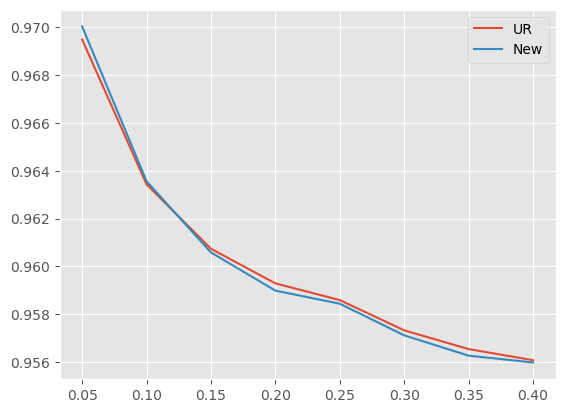

In [208]:
plt.style.use("ggplot")

plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rUsr), label='UR')
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rItm), label='New')
plt.legend()


def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

fig = plt.gcf()
tikzplotlib_fix_ncols(fig)

print(tikzplotlib.get_tikz_code())

2858


100%|█████████████████████████████████████████| 100/100 [11:22<00:00,  6.82s/it]


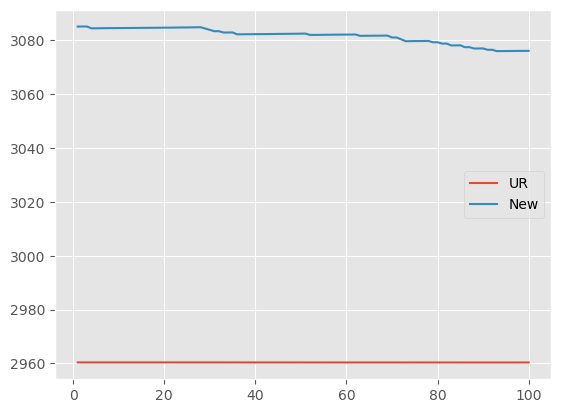

In [210]:
ranksUR, _ = UserRepRank(userDict, itemDict)
ranksAA, _ = UserRepRank(userDict, itemDict, nIt=0, lbda=0)
ranksNew = filterRank(itemDict)

mri = reduce(lambda r, x: r if len(itemDict[r]) > len(itemDict[x]) else x, itemDict.keys())
print(mri)
userMRI = len(itemDict[mri])
profitUR, profitAA, profitNew = [], [], []
wealthUR, wealthAA, wealthNew = ranksUR[mri]*userMRI, ranksAA[mri]*userMRI, ranksNew[mri]*userMRI

userDictCpy = {k:[(a,b) for a,b in v] for k,v in userDict.items()}
itemDictCpy = {k:[(a,b) for a,b in v] for k,v in itemDict.items()}

userNonMax = list(filter(lambda x: x[1] < 1, itemDictCpy[mri]))   

cost = 0
for (u, r) in tqdm(userNonMax[:100]):
    cost += abs(1-r)
    itemDictCpy[mri] = [(usr, rat) for (usr, rat) in itemDictCpy[mri] if usr != u] + [(u, 1)]
    userDictCpy[u]   = [(itm, rat) for (itm, rat) in userDictCpy[u] if itm != mri] + [(mri, 1)]
    ranksUR_, _ = UserRepRank(userDictCpy, itemDictCpy)
    #ranksAA_, _ = UserRepRank(userDictCpy, itemDictCpy, nIt=0, lbda=0)
    ranksNew_ = filterRank(itemDictCpy)
    profUR = ranksUR_[mri]*userMRI - cost
    profNew = ranksNew_[mri]*userMRI - cost
    if profUR < 0 or profNew < 0:
        break
    profitUR.append(profUR)    
    profitNew.append(profNew)

plt.plot(list(range(1, len(profitUR)+1)), profitUR, label='UR')
plt.plot(list(range(1, len(profitNew)+1)), profitNew, label='New')
plt.legend()

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{crimson2143940}{RGB}{214,39,40}
\definecolor{dimgray85}{RGB}{85,85,85}
\definecolor{gainsboro229}{RGB}{229,229,229}
\definecolor{lightgray204}{RGB}{204,204,204}
\definecolor{steelblue31119180}{RGB}{31,119,180}

\begin{axis}[
axis background/.style={fill=gainsboro229},
axis line style={white},
tick align=outside,
tick pos=left,
x grid style={white},
xmajorgrids,
xmin=-3.95, xmax=104.95,
xtick style={color=dimgray85},
y grid style={white},
ylabel=\textcolor{crimson2143940}{UR},
ymajorgrids,
ymin=2960.35552733646, ymax=2960.39039472362,
ytick style={color=dimgray85},
ytick={2960.355,2960.36,2960.365,2960.37,2960.375,2960.38,2960.385,2960.39,2960.395},
yticklabels={0.055,0.060,0.065,0.070,0.075,0.080,0.085,0.090,0.095}
]
\addplot [semithick, crimson2143940]
table {%
1 2960.38739455663
2 2960.38739693648
3 2960.38671108343
4 2960.387751027
5 2960.38858387305
6 2960.38792446684
7 2960.38602036838
8 2960.38661

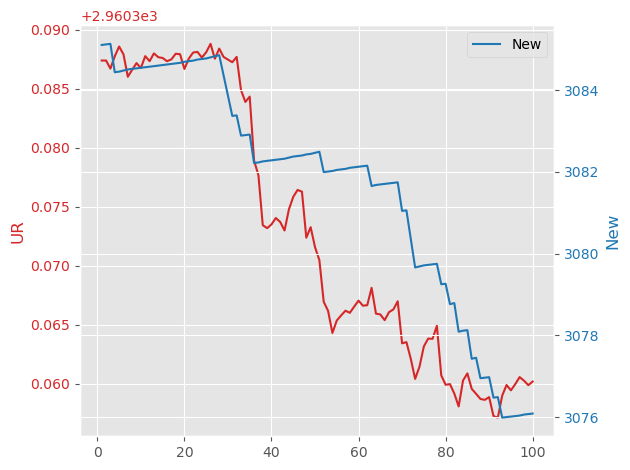

In [211]:
# Create some mock data
import numpy as np

t = list(range(1, len(profitNew)+1))
data1 = profitUR
data2 = profitNew

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('UR', color=color)
ax1.plot(t, data1, color=color, label='UR')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('New', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color, label='New')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.legend()

fig = plt.gcf()
tikzplotlib_fix_ncols(fig)

print(tikzplotlib.get_tikz_code())

In [3]:
userDict, itemDict = {}, {}
f = open('ratings_Musical_Instruments.csv')
for line in f.readlines():
    usr, itm, rat = line.split(',')[:-1]
    rat = float(rat)/5
    if usr in userDict:
        userDict[usr].append((itm, rat))
    else:
        userDict[usr] = [(itm, rat)]
    if itm in itemDict:
        itemDict[itm].append((usr, rat))
    else:
        itemDict[itm] = [(usr, rat)]
f.close()

In [266]:
len(userDict.keys()), len(itemDict.keys()), sum([len(v) for v in itemDict.values()])

(339231, 83046, 500176)

In [224]:
reduce(lambda r,x:set(list(r)+[y[1] for y in x]), itemDict.values(),[])

{0.2, 0.4, 0.6, 0.8, 1.0}

In [226]:
round(.5+numpy.std([len(v) for _, v in userDict.items()]))

3

In [228]:
max([len(v) for _, v in userDict.items()])

483

In [247]:
%timeit UserRepRank(userDict, itemDict, nIt=0, lbda=0)

587 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [256]:
%timeit filterRankFast(itemDict)

2.56 s ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [255]:
%timeit UserRepRank(userDict, itemDict, nIt=20, lbda=0.1)

13 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
rankings, _ = UserRepRank(userDict, itemDict, nIt=0, lbda=0)
rankingsI = filterRank(itemDict)
rankingsU, _ = UserRepRank(userDict, itemDict, nIt=20, lbda=0.5)

In [12]:
from scipy.stats import kendalltau

In [16]:
kendalltau(list(rankings.values()), list(rankingsU.values()))

SignificanceResult(statistic=0.9800940702728757, pvalue=0.0)

In [17]:
kendalltau(list(rankings.values()), list(rankingsI.values()))

SignificanceResult(statistic=0.9514436242567055, pvalue=0.0)

100%|██████████████████████████████████████████| 8/8 [1:50:21<00:00, 827.68s/it]


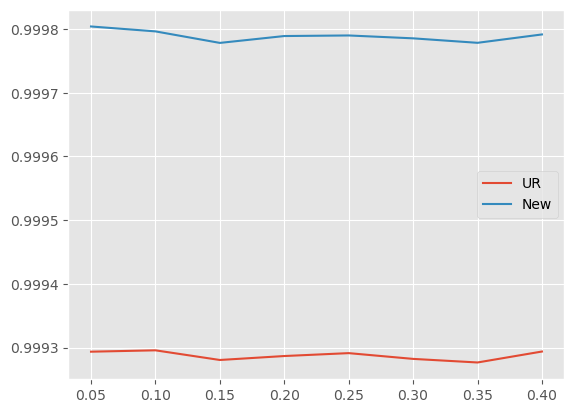

In [229]:
rankings, _ = UserRepRank(userDict, itemDict, nIt=0, lbda=0)
rankingsI = filterRank(itemDict)
rankingsU, _ = UserRepRank(userDict, itemDict, nIt=20, lbda=0.1)

n_usr = len(userDict.keys())

N, K = 30, 5*round(.5+numpy.mean([len(v) for _, v in userDict.items()]))
rAA = [[] for i in range(N)]
rItm = [[] for i in range(N)]
rUsr = [[] for i in range(N)]

for spam in tqdm([.05,.1,.15,.2,.25,.3,.35,.4]):
    for i in range(N):
        userDict_perc = {k:[(a,b) for a,b in v] for k,v in userDict.items()}
        itemDict_perc = {k:[(a,b) for a,b in v] for k,v in itemDict.items()}
        randomItems = random.sample(list(itemDict.keys()), K)
        for u in range(n_usr+1, int((spam+1)*(n_usr))):
            typ = 0 #random.sample([0,1,2], 1)[0]
            for itm in randomItems:
                rtng = [random.sample(list(range(1,6)), 1)[0]/5, 1/5, 1.0][typ]
                userDict_perc[u] = [(itm, rtng)]
                itemDict_perc[itm] += [(u, rtng)]

        rnks = filterRank(itemDict_perc)
        rItm[i] += [(spam, kendalltau(list(rankingsI.values()),list(rnks.values()))[0])]
        rnks, _ = UserRepRank(userDict_perc, itemDict_perc, nIt=20, lbda=.1)
        rUsr[i] += [(spam, kendalltau(list(rankingsU.values()),list(rnks.values()))[0])]
        #rnks, _ = UserRepRank(userDict_perc, itemDict_perc, nIt=0, lbda=0)
        #rAA[i] += [(spam, kendalltau(list(rankings.values()),list(rnks.values()))[0])]
#plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rAA), label='AA')
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rUsr), label='UR')
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rItm), label='New')
plt.legend()

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{chocolate2267451}{RGB}{226,74,51}
\definecolor{dimgray85}{RGB}{85,85,85}
\definecolor{gainsboro229}{RGB}{229,229,229}
\definecolor{lightgray204}{RGB}{204,204,204}
\definecolor{steelblue52138189}{RGB}{52,138,189}

\begin{axis}[
axis background/.style={fill=gainsboro229},
axis line style={white},
legend cell align={left},
legend style={
  fill opacity=0.8,
  draw opacity=1,
  text opacity=1,
  at={(0.91,0.5)},
  anchor=east,
  draw=lightgray204,
  fill=gainsboro229
},
tick align=outside,
tick pos=left,
x grid style={white},
xmajorgrids,
xmin=0.0325, xmax=0.4175,
xtick style={color=dimgray85},
y grid style={white},
ymajorgrids,
ymin=0.999250254978333, ymax=0.999830482636544,
ytick style={color=dimgray85}
]
\addplot [semithick, chocolate2267451]
table {%
0.05 0.999293567572612
0.1 0.999295715473339
0.15 0.999280541686589
0.2 0.9992867491483
0.25 0.999291302737898
0.3 0.999282263153305
0.35 0.999276628962797

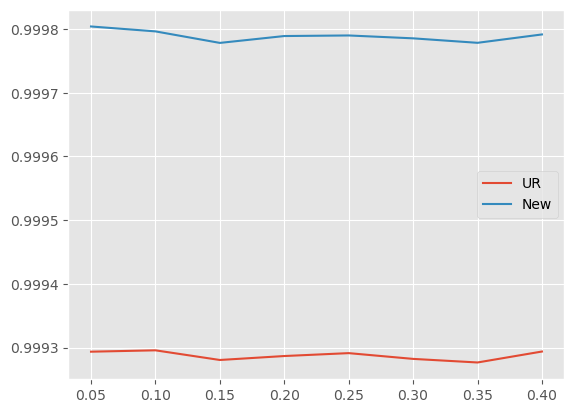

In [233]:
plt.style.use("ggplot")

plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rUsr), label='UR')
plt.plot([.05,.1,.15,.2,.25,.3,.35,.4], plotAvg(rItm), label='New')
plt.legend()


def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

fig = plt.gcf()
tikzplotlib_fix_ncols(fig)

print(tikzplotlib.get_tikz_code())

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{crimson2143940}{RGB}{214,39,40}
\definecolor{dimgray85}{RGB}{85,85,85}
\definecolor{gainsboro229}{RGB}{229,229,229}
\definecolor{lightgray204}{RGB}{204,204,204}
\definecolor{steelblue31119180}{RGB}{31,119,180}

\begin{axis}[
axis background/.style={fill=gainsboro229},
axis line style={white},
tick align=outside,
tick pos=left,
x grid style={white},
xmajorgrids,
xmin=0.0325, xmax=0.4175,
xtick style={color=dimgray85},
y grid style={white},
ylabel=\textcolor{crimson2143940}{UR},
ymajorgrids,
ymin=0.99927567463727, ymax=0.999296669798866,
ytick style={color=dimgray85},
ytick={0.999275,0.9992775,0.99928,0.9992825,0.999285,0.9992875,0.99929,0.9992925,0.999295,0.9992975},
yticklabels={7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75}
]
\addplot [semithick, crimson2143940]
table {%
0.05 0.999293567572612
0.1 0.999295715473339
0.15 0.999280541686589
0.2 0.9992867491483
0.25 0.999291302737898
0.3 0.999282263153

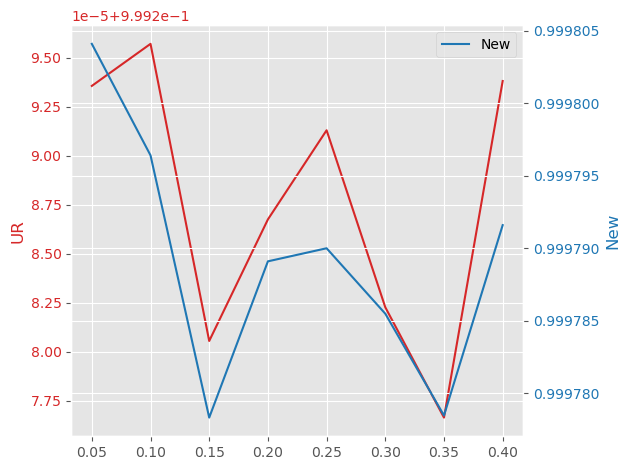

In [231]:
t = [.05,.1,.15,.2,.25,.3,.35,.4]
data1 = plotAvg(rUsr)
data2 = plotAvg(rItm)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('UR', color=color)
ax1.plot(t, data1, color=color, label='UR')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('New', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color, label='New')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.legend()

fig = plt.gcf()
tikzplotlib_fix_ncols(fig)

print(tikzplotlib.get_tikz_code())

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{chocolate2267451}{RGB}{226,74,51}
\definecolor{dimgray85}{RGB}{85,85,85}
\definecolor{gainsboro229}{RGB}{229,229,229}
\definecolor{mediumpurple152142213}{RGB}{152,142,213}
\definecolor{steelblue52138189}{RGB}{52,138,189}

\begin{axis}[
axis background/.style={fill=gainsboro229},
axis line style={white},
tick align=outside,
tick pos=left,
x grid style={white},
xmajorgrids,
xmin=0.1688, xmax=1.0312,
xtick style={color=dimgray85},
y grid style={white},
ymajorgrids,
ymin=0, ymax=46165.35,
ytick style={color=dimgray85}
]
\draw[draw=none,fill=chocolate2267451,very thin] (axis cs:0.208,0) rectangle (axis cs:0.229333333333333,2715);
\addlegendimage{ybar,ybar legend,draw=none,fill=chocolate2267451,very thin}
\addlegendentry{AA}

\draw[draw=none,fill=chocolate2267451,very thin] (axis cs:0.288,0) rectangle (axis cs:0.309333333333333,284);
\draw[draw=none,fill=chocolate2267451,very thin] (axis cs:0.368,0) rectangle

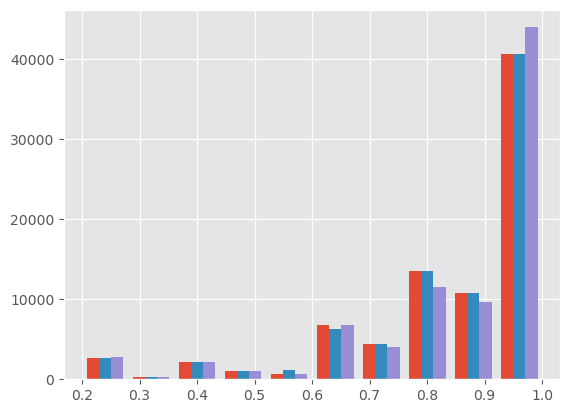

In [222]:
plt.style.use("ggplot")

x, y, z = list(rankings.values()), list(rankingsU.values()), list(rankingsI.values())

plt.hist([x, y, z], label=['AA', 'UR', 'New'])
plt.grid(True)
#plt.show()

print(tikzplotlib.get_tikz_code())

B000ULAP4U


100%|█████████████████████████████████████████| 100/100 [15:07<00:00,  9.07s/it]


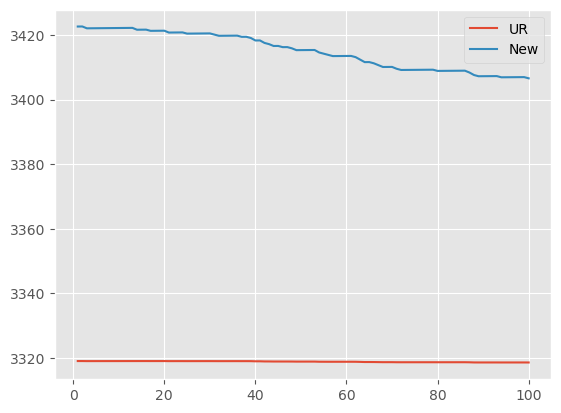

In [230]:
ranksUR, _ = UserRepRank(userDict, itemDict)
ranksAA, _ = UserRepRank(userDict, itemDict, nIt=0, lbda=0)
ranksNew = filterRank(itemDict)

mri = reduce(lambda r, x: r if len(itemDict[r]) > len(itemDict[x]) else x, itemDict.keys())
print(mri)
userMRI = len(itemDict[mri])
profitUR, profitAA, profitNew = [], [], []
wealthUR, wealthAA, wealthNew = ranksUR[mri]*userMRI, ranksAA[mri]*userMRI, ranksNew[mri]*userMRI

userDictCpy = {k:[(a,b) for a,b in v] for k,v in userDict.items()}
itemDictCpy = {k:[(a,b) for a,b in v] for k,v in itemDict.items()}

userNonMax = list(filter(lambda x: x[1] < 1, itemDictCpy[mri]))   

cost = 0
for (u, r) in tqdm(userNonMax[:100]):
    cost += abs(1-r)
    itemDictCpy[mri] = [(usr, rat) for (usr, rat) in itemDictCpy[mri] if usr != u] + [(u, 1)]
    userDictCpy[u]   = [(itm, rat) for (itm, rat) in userDictCpy[u] if itm != mri] + [(mri, 1)]
    ranksUR_, _ = UserRepRank(userDictCpy, itemDictCpy)
    #ranksAA_, _ = UserRepRank(userDictCpy, itemDictCpy, nIt=0, lbda=0)
    ranksNew_ = filterRank(itemDictCpy)
    profUR = ranksUR_[mri]*userMRI - cost
    profNew = ranksNew_[mri]*userMRI - cost
    if profUR < 0 or profNew < 0:
        break
    profitUR.append(profUR)    
    profitNew.append(profNew)

plt.plot(list(range(1, len(profitUR)+1)), profitUR, label='UR')
plt.plot(list(range(1, len(profitNew)+1)), profitNew, label='New')
plt.legend()

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{crimson2143940}{RGB}{214,39,40}
\definecolor{dimgray85}{RGB}{85,85,85}
\definecolor{gainsboro229}{RGB}{229,229,229}
\definecolor{lightgray204}{RGB}{204,204,204}
\definecolor{steelblue31119180}{RGB}{31,119,180}

\begin{axis}[
axis background/.style={fill=gainsboro229},
axis line style={white},
tick align=outside,
tick pos=left,
x grid style={white},
xmajorgrids,
xmin=-3.95, xmax=104.95,
xtick style={color=dimgray85},
y grid style={white},
ylabel=\textcolor{crimson2143940}{UR},
ymajorgrids,
ymin=3318.59956011544, ymax=3319.08402074664,
ytick style={color=dimgray85}
]
\addplot [semithick, crimson2143940]
table {%
1 3319.06066253185
2 3319.06199980886
3 3319.04289676944
4 3319.04480084593
5 3319.04611981726
6 3319.04743550506
7 3319.04874790539
8 3319.05005701443
9 3319.05136282831
10 3319.05266534301
11 3319.05396455483
12 3319.05526045976
13 3319.05655305401
14 3319.0575314483
15 3319.05881286363
16 3319.

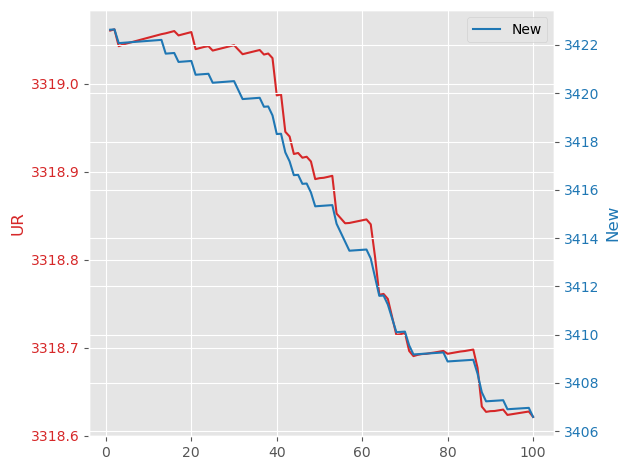

In [232]:
t = list(range(1, len(profitUR)+1))
data1 = profitUR
data2 = profitNew

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('UR', color=color)
ax1.plot(t, data1, color=color, label='UR')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('New', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color, label='New')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.legend()

fig = plt.gcf()
tikzplotlib_fix_ncols(fig)

print(tikzplotlib.get_tikz_code())